In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.8 MB/s eta 0:00:00


In [3]:
def tokenize_and_prepare(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}, text


In [4]:
!pip install torch

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

data = pd.read_excel('/content/drive/MyDrive/Thesis/data.xlsx')
data = data[['paragraph', 'form']]

import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Приведение к нижнему регистру
data['paragraph'] = data['paragraph'].str.lower()

# Удаление стоп-слов
stop_words = set(stopwords.words('russian'))
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Лемматизация
lemmatizer = WordNetLemmatizer()
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Удаление пунктуации и специальных символов
data['paragraph'] = data['paragraph'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

model_name = "bert-base-uncased"  # You can change this to your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def tokenize_and_prepare(row):
    text = row['paragraph']
    complexity = row['form']
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}, complexity



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучение:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Обучение:  20%|██        | 1/5 [09:21<37:26, 561.65s/it]

Epoch 1: Average Loss: 8.21945943419635


Обучение:  40%|████      | 2/5 [18:40<27:59, 559.86s/it]

Epoch 2: Average Loss: 2.075286854762363


Обучение:  60%|██████    | 3/5 [27:56<18:36, 558.08s/it]

Epoch 3: Average Loss: 2.1702710089792046


Обучение:  80%|████████  | 4/5 [37:10<09:16, 556.39s/it]

Epoch 4: Average Loss: 2.580628470002908


Обучение: 100%|██████████| 5/5 [46:22<00:00, 556.42s/it]

Epoch 5: Average Loss: 1.802512536717373


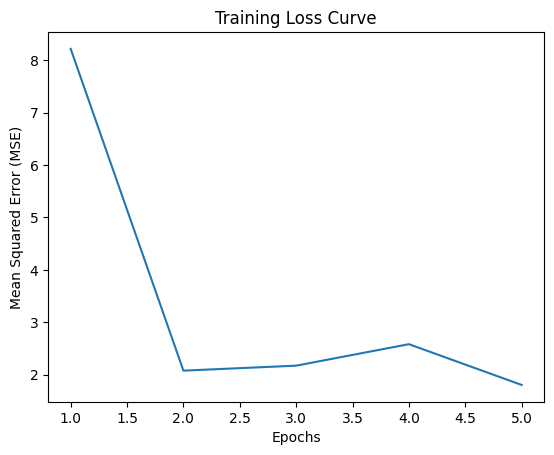

In [6]:
from tqdm import tqdm

tokenized_data = data.apply(tokenize_and_prepare, axis=1)

max_length = 256

input_ids_list = []
attention_mask_list = []

for item in tokenized_data:
    input_ids = item[0]['input_ids']
    attention_mask = item[0]['attention_mask']

    if input_ids.shape[1] > max_length:
        input_ids = input_ids[:, :max_length]
        attention_mask = attention_mask[:, :max_length]
    elif input_ids.shape[1] < max_length:
        padding_length = max_length - input_ids.shape[1]
        input_ids = torch.cat([input_ids, torch.zeros((1, padding_length), dtype=torch.long)], dim=1)
        attention_mask = torch.cat([attention_mask, torch.zeros((1, padding_length), dtype=torch.long)], dim=1)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)
inputs_dict = {
    'input_ids': torch.stack(input_ids_list),
    'attention_mask': torch.stack(attention_mask_list)
}
labels = torch.tensor([item[1] for item in tokenized_data], dtype=torch.float32)
input_ids_tensor = inputs_dict['input_ids']
attention_mask_tensor = inputs_dict['attention_mask']
tensor_list = [input_ids_tensor, attention_mask_tensor, labels]
dataset = TensorDataset(*tensor_list)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()
train_losses = []
epochs = 5


for epoch in tqdm(range(epochs), desc="Обучение"):
    total_loss = 0
    for batch in dataset:
        optimizer.zero_grad()
        input_ids = batch[0]
        attention_mask = batch[1]
        output = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(output.logits.squeeze(), batch[2])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}: Average Loss: {avg_loss}")

plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, test_predictions)
print(f"Mean Squared Error on Test Data: {mse}")


In [ ]:
from sklearn.metrics import r2_score

r_squared = r2_score(test_labels, test_predictions)
print(f"R-squared: {r_squared}")


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_labels, test_predictions)
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")


In [ ]:
model_directory = '/content/drive/MyDrive/Thesis/best model'

model.save_pretrained(model_directory)
tokenizer.save_pretrained(model_directory)


In [ ]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Приведение к нижнему регистру
data['paragraph'] = data['paragraph'].str.lower()

# Удаление стоп-слов
stop_words = set(stopwords.words('english'))
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Лемматизация
lemmatizer = WordNetLemmatizer()
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Удаление пунктуации и специальных символов
data['paragraph'] = data['paragraph'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Загрузка списка стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

word_tokens = word_tokenize(text, language='russian')
filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

# Преобразование обратно в текст
filtered_text = ' '.join(filtered_text)
print(filtered_text)


КОРРЕЛЯЦИЯ КЛАСС - ОЦЕНКА GPT

In [ ]:
import pandas as pd

data = pd.read_excel('/content/drive/MyDrive/Thesis/data.xlsx')
data = data[['0-5', 'form']]
data.head()

,0-5,form
0,2,5
1,2,5
2,3,5
3,1,5
4,2,5


In [ ]:
# вычисляем корреляцию (Спирмен)
import scipy
from scipy.stats import pearsonr
from scipy.stats import spearmanr

asses =  data['0-5']

form = data['form']

corr, p_value = spearmanr(asses, form)

In [ ]:
print(f"Spearman correlation coefficient: {corr}")
print(f"P-value: {p_value}")


Spearman correlation coefficient: 0.32115709234197504
P-value: 0.00010319304143707395


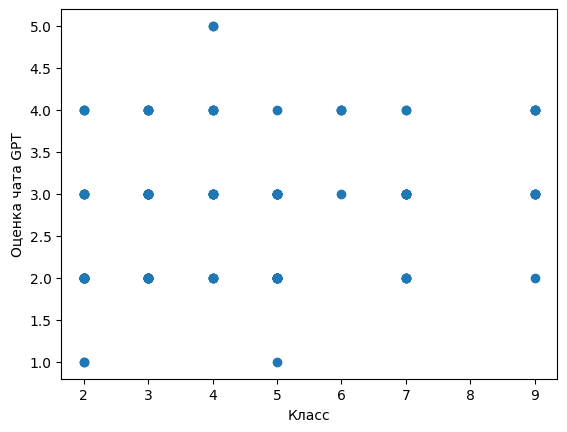

In [ ]:
import matplotlib.pyplot as plt

plt.plot(form, asses, 'o')
plt.xlabel('Класс')
plt.ylabel('Оценка чата GPT')
plt.title('')
plt.show()
